## Bike rental demand prediction using Machine Learning

### Preprocessing: 
To make the data suitable for machine learning, we are going to do some preprocessing, including, handling missing data, transform some columns, etc.

* Use One hot encoding or pd.get_dummies() to convert ordinal, binary and all other categorical columns to numeric
* Data Transformation (Optional): Standardization/Normalization/log/sqrt especially if you are using distance based algorithms like KNN, or Neural Networks.


### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
plt.rcParams['figure.figsize'] = (12.0, 5.0)

### Load Data

In [2]:
df = pd.read_csv('../data/train.csv', header = 0, error_bad_lines=False)
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [4]:
# Total number of unique values in every column

df.apply(lambda col: col.nunique())

datetime      10886
season            4
holiday           2
workingday        2
weather           4
temp             49
atemp            60
humidity         89
windspeed        28
casual          309
registered      731
count           822
dtype: int64

### Missing Values

In [5]:
# Handling Missing Values
num_missing = df.isnull().sum()
missing_per = (num_missing/df.shape[0])*100
missing_table = pd.concat([num_missing,missing_per], axis=1, ignore_index=True) 
missing_table.rename(columns={0:'Num_Missing',1:'%_Missing'}, inplace=True)
print('\033[1m' + '\033[94m' + 'Missing Data Info:'.center(80) + '\033[0m')
print(missing_table)

                               Missing Data Info:                               
            Num_Missing  %_Missing
datetime              0        0.0
season                0        0.0
holiday               0        0.0
workingday            0        0.0
weather               0        0.0
temp                  0        0.0
atemp                 0        0.0
humidity              0        0.0
windspeed             0        0.0
casual                0        0.0
registered            0        0.0
count                 0        0.0


No missing data handle

### Feature Engineering

In [6]:
def parse_datetime(df):

    # Convert the datetime col in datetime format
    df['datetime'] = pd.to_datetime(df.datetime)

    # extract month, day, weekday, and hour from datetime
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['weekday'] = df['datetime'].dt.dayofweek
    df['hour'] = df['datetime'].dt.hour

    #rearrange columns
    df = df.set_index('datetime')
    df = df[['month','day', 'weekday', 'hour','season','holiday','workingday','weather','temp','atemp','humidity','windspeed','casual','registered','count']]
    return df

df = parse_datetime(df)
df

,month,day,weekday,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,1,5,0,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
2011-01-01 01:00:00,1,1,5,1,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2011-01-01 02:00:00,1,1,5,2,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
2011-01-01 03:00:00,1,1,5,3,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
2011-01-01 04:00:00,1,1,5,4,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,12,19,2,19,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
2012-12-19 20:00:00,12,19,2,20,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
2012-12-19 21:00:00,12,19,2,21,4,0,1,1,13.94,15.910,61,15.0013,4,164,168


In [7]:
df.columns

Index(['month', 'day', 'weekday', 'hour', 'season', 'holiday', 'workingday',
       'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'casual',
       'registered', 'count'],
      dtype='object')

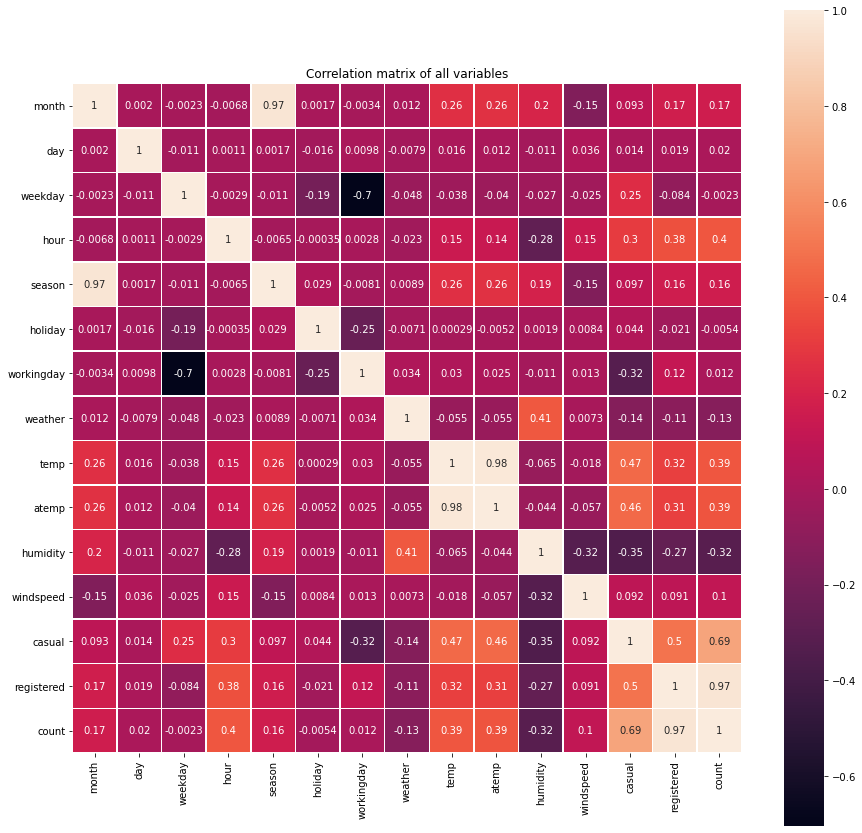

In [8]:
# Feature Selection using correlation heatmap to reduce redundant info in model devolopment
plt.figure(figsize=(15,15))
_ = sns.heatmap(df.corr(),linewidths=0.5,linecolor='w',square=True,annot=True)
plt.title('Correlation matrix of all variables')
# plt.savefig('correlation.png')
plt.show()

In [9]:
df.corr()["count"]

month         0.166862
day           0.019826
weekday      -0.002283
hour          0.400601
season        0.163439
holiday      -0.005393
workingday    0.011594
weather      -0.128655
temp          0.394454
atemp         0.389784
humidity     -0.317371
windspeed     0.101369
casual        0.690414
registered    0.970948
count         1.000000
Name: count, dtype: float64

**Notable Observation from heatmap:**
* Hour, temp, & atemp are posively correlated to our target variable, count while humidity is negatively correlated to count.
* The rest of the variables(month, day, weekday, holiday, workingday, windspeed) have very weak to no corralation with the target variable.
* Count equals the sum of the casual + registered columns, it is therefore not surprising that they are strongly posively correlated to the target, & will be dropped because we do not want to cheat by using information we will not have when making predictions.
* Temp & atemp which are both temperature values are strongly positively correlation with each other and will be merged to create new feature.
* Concerning feature selection/dropping, there are more effiecient statistical ways of doing so using methods like ANOVA test, Chi-square test, etc. but for the purpose of this project we will not consider those.


In [10]:
def handle_outliers(df):
    '''Outlier must be treated one column at a time since treatment will be slightly different for each column.
       Outliers bias the training of machine learning models and must be either deleted when it's only few rows 
       or imputed with a logical business value.

    for i in ['temp','atemp','humidity','windspeed','casual','registered','count']:
        upper_limit = df[i].quantile(.99)
        lower_limit = df[i].quantile(.01)
        df = df[(df[i] < upper_limit) & (df[i] > lower_limit)]
    return df
    '''

In [12]:
def feature_transformation(df):

    #Creat a new variable 'day_typ' to categorize a day as either weekend, holiday, or workday 
    '''#df['day_typ'] = np.where( ( (df['holiday'] == 0) & (df['workingday'] == 0 ) ) , 0,0)
        #df['day_typ'] = np.where( ( df['holiday']== 1) , 1,0)
        #df['day_typ'] = np.where( ( (df['holiday'] == 0) & (df['workingday'] == 1 ) ) , 2,0)
        '''
        
    df.loc[(df['holiday']==0) & (df['workingday']==0),'day_typ'] = 'weekend'
    df.loc[(df['holiday']==1),'day_typ'] = 'holiday'
    df.loc[(df['holiday']==0) & (df['workingday']==1),'day_typ'] = 'workday'
        

    #Label/Bin the hour distribution to categorize off-peak, average and peak situations
    df['hour_typ'] = df['hour'].map(lambda x:4 if 0 <= x < 6 else(1 if 6 <= x < 12 else(2 if 12 <= x < 19 else(3 if x>=19 else 0))))

    #Aggregate those temp & atemp to derive a new feature 'm_temp' representing mean of the 2 temperature values
    columns = ['temp','atemp']
    df['m_temp'] = df.apply(lambda row: row[columns].mean(), axis=1)
    
    #rearrange columns
    #df = df[['month','day', 'day_typ', 'weekday','hour', 'hour_typ','season', 'holiday','workingday', 'weather', 'temp','atemp', 'm_temp', 'humidity','windspeed','casual','registered','count']]

    return df

df = feature_transformation(df)
df

,month,day,weekday,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,day_typ,hour_typ,m_temp
datetime,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,1,5,0,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,weekend,4,12.1175
2011-01-01 01:00:00,1,1,5,1,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,weekend,4,11.3275
2011-01-01 02:00:00,1,1,5,2,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,weekend,4,11.3275
2011-01-01 03:00:00,1,1,5,3,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,weekend,4,12.1175
2011-01-01 04:00:00,1,1,5,4,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,weekend,4,12.1175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,12,19,2,19,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,workday,3,17.6375
2012-12-19 20:00:00,12,19,2,20,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,workday,3,16.0925
2012-12-19 21:00:00,12,19,2,21,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,workday,3,14.9250


In [13]:
df.nunique()

month          12
day            19
weekday         7
hour           24
season          4
holiday         2
workingday      2
weather         4
temp           49
atemp          60
humidity       89
windspeed      28
casual        309
registered    731
count         822
day_typ         3
hour_typ        4
m_temp        255
dtype: int64

In [14]:
#feature scaling/normalization

df_num = ['m_temp','humidity','windspeed']
def normalize(df):
    
    for i in df_num:
        max_value = df[i].max()
        min_value = df[i].min()
        df[i] = (df[i] - min_value) / (max_value - min_value)
    return df

df = normalize(df)
df

,month,day,weekday,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,day_typ,hour_typ,m_temp
datetime,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,1,5,0,1,0,0,1,9.84,14.395,0.81,0.000000,3,13,16,weekend,4,0.272181
2011-01-01 01:00:00,1,1,5,1,1,0,0,1,9.02,13.635,0.80,0.000000,8,32,40,weekend,4,0.253199
2011-01-01 02:00:00,1,1,5,2,1,0,0,1,9.02,13.635,0.80,0.000000,5,27,32,weekend,4,0.253199
2011-01-01 03:00:00,1,1,5,3,1,0,0,1,9.84,14.395,0.75,0.000000,3,10,13,weekend,4,0.272181
2011-01-01 04:00:00,1,1,5,4,1,0,0,1,9.84,14.395,0.75,0.000000,0,1,1,weekend,4,0.272181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,12,19,2,19,4,0,1,1,15.58,19.695,0.50,0.456213,7,329,336,workday,3,0.404818
2012-12-19 20:00:00,12,19,2,20,4,0,1,1,14.76,17.425,0.57,0.263195,10,231,241,workday,3,0.367694
2012-12-19 21:00:00,12,19,2,21,4,0,1,1,13.94,15.910,0.61,0.263195,4,164,168,workday,3,0.339641


In [15]:
def feature_encoding(df):

    #one hot encode the categorical variables into binary codes
    cat_features = ['day_typ','hour_typ','season','weather']
    encoded_features = []
    for feature in cat_features:

        encoded_feat = OneHotEncoder().fit_transform(df[feature].values.reshape(-1,1)).toarray()
        n = df[feature].nunique()
        cols = ['{}_{}'.format(feature, n) for n in range(1, n+1)]
        encoded_df = pd.DataFrame(encoded_feat, columns=cols)
        encoded_df.index = df.index
        encoded_features.append(encoded_df)

    df = pd.concat([df, *encoded_features], axis=1)

    return df

df = feature_encoding(df)
df

,month,day,weekday,hour,season,holiday,workingday,weather,temp,atemp,...,hour_typ_3,hour_typ_4,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
datetime,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,1,5,0,1,0,0,1,9.84,14.395,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2011-01-01 01:00:00,1,1,5,1,1,0,0,1,9.02,13.635,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2011-01-01 02:00:00,1,1,5,2,1,0,0,1,9.02,13.635,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2011-01-01 03:00:00,1,1,5,3,1,0,0,1,9.84,14.395,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2011-01-01 04:00:00,1,1,5,4,1,0,0,1,9.84,14.395,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,12,19,2,19,4,0,1,1,15.58,19.695,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2012-12-19 20:00:00,12,19,2,20,4,0,1,1,14.76,17.425,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2012-12-19 21:00:00,12,19,2,21,4,0,1,1,13.94,15.910,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [16]:
df.nunique()

month          12
day            19
weekday         7
hour           24
season          4
holiday         2
workingday      2
weather         4
temp           49
atemp          60
humidity       89
windspeed      28
casual        309
registered    731
count         822
day_typ         3
hour_typ        4
m_temp        255
day_typ_1       2
day_typ_2       2
day_typ_3       2
hour_typ_1      2
hour_typ_2      2
hour_typ_3      2
hour_typ_4      2
season_1        2
season_2        2
season_3        2
season_4        2
weather_1       2
weather_2       2
weather_3       2
weather_4       2
dtype: int64

In [17]:
def unwanted_cols(df):

    #Drop columns unneeded for modeling, including those which we have created new label and one hot encoded variants out of
    df = df.drop(['hour','hour_typ','season','month', 'day', 'day_typ', 'weekday', 'holiday', 'workingday', 'weather','temp', 'atemp', 'casual', 'registered'], axis=1)
    return df

df = unwanted_cols(df)
df

,humidity,windspeed,count,m_temp,day_typ_1,day_typ_2,day_typ_3,hour_typ_1,hour_typ_2,hour_typ_3,hour_typ_4,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
datetime,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,0.81,0.000000,16,0.272181,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2011-01-01 01:00:00,0.80,0.000000,40,0.253199,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2011-01-01 02:00:00,0.80,0.000000,32,0.253199,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2011-01-01 03:00:00,0.75,0.000000,13,0.272181,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2011-01-01 04:00:00,0.75,0.000000,1,0.272181,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,0.50,0.456213,336,0.404818,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2012-12-19 20:00:00,0.57,0.263195,241,0.367694,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2012-12-19 21:00:00,0.61,0.263195,168,0.339641,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [18]:
df.describe()

,humidity,windspeed,count,m_temp,day_typ_1,day_typ_2,day_typ_3,hour_typ_1,hour_typ_2,hour_typ_3,hour_typ_4,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,0.618865,0.224563,191.574132,0.508271,0.028569,0.290557,0.680875,0.250781,0.293221,0.209443,0.246555,0.246739,0.251056,0.251056,0.251148,0.660665,0.260334,0.078909,0.000092
std,0.192450,0.143245,181.144454,0.194689,0.166599,0.454040,0.466159,0.433482,0.455260,0.406930,0.431025,0.431133,0.433641,0.433641,0.433694,0.473505,0.438837,0.269609,0.009584
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.470000,0.122840,42.000000,0.348711,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.620000,0.228047,145.000000,0.518532,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.770000,0.298225,284.000000,0.661080,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,977.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
df.nunique()

humidity       89
windspeed      28
count         822
m_temp        255
day_typ_1       2
day_typ_2       2
day_typ_3       2
hour_typ_1      2
hour_typ_2      2
hour_typ_3      2
hour_typ_4      2
season_1        2
season_2        2
season_3        2
season_4        2
weather_1       2
weather_2       2
weather_3       2
weather_4       2
dtype: int64